In [1]:
from qiskit import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
import math

sim = Aer.get_backend('qasm_simulator')

# Algorithme de Grover

C'est un algorithme permettant de trouver un élément dans une base de données non-triée. En effet, pour $N$ éléments, il faut $N$ étapes de manière classque contre $\sqrt{N}$ avec l'algorithme de Grover. On peut l'utiliser par exemple pour résoudre un problème avec des contraintes : l'espace des solutions représente notre base de données et celles répondant à la contrainte sont les éléments recherchés.

Voici le principe du circuit, on initialise d'abord le circuit puis on répéte un certains nombre de fois les opérations d'oracle et de diffuseur avant de mesurer. On devrait alors quasi certainement mesurer la bonne solution.

![Principe du circuit](Images/grov-princ.png)

On peut y offrir une jolie intuition géométrique. On considère l'espace des solution avec les vecteurs orthogonaux $\ket{w}$ recherchés et $\ket{s'}$ non-recherchés.

L'initialisation crée une superposition équilibrée des éléments.

![Initialisation](Images/grov-ini.png)

L'oracle marque les bons éléments en inverant leur phase.

![Oracle](Images/grov-oracle.png)

Le diffuseur crée alors une symétrie par rapport à la moyenne des amplitudes.

![Diffuseur](Images/grov-diff.png)

Avec cette intuition, on peut déduire géométriquement qu'il faut $\lfloor \frac{\pi}{4} \sqrt{\frac{N}{m}} \rfloor$ étapes avec $N$ la taille de l'espace et $m$ le nombre de solution valide (peut être trouvé grace à l'oracle et une estimation de phase).

## Application

On peut résoudre par exemple un sudoku.

Voyons comment cela fonctionne pour celui suivant :

|1| | |
|-|-|-|
|**2**| |**1**|
| |**1**| |

Comme vous le voyez, tout les 1 sont déjà placé car sinon c'est impossible à simuler.

Construisons donc les différents éléments.

In [2]:
input_reg = QuantumRegister(5, name='input')
cond_reg = QuantumRegister(6, name='cond')
kick_reg = QuantumRegister(1, name='kick')
mes_reg = ClassicalRegister(5, name='mes')

In [3]:
# Nombres d'itérations
num_it = int(np.floor(np.pi / 4 * np.sqrt(2**5)))
num_it

4

Construisons l'étape d'initialisation.

c:\Python310\lib\site-packages\qiskit\visualization\circuit\matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


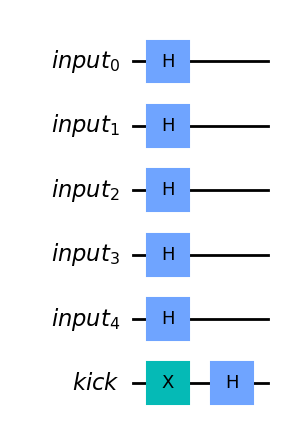

In [4]:
# initialisation
init = QuantumCircuit(input_reg, kick_reg)

init.h(input_reg)

init.x(kick_reg)
init.h(kick_reg)

display(init.draw('mpl'))

init = init.to_gate(label="Initialisation")

Pour l'oracle, nous vérifions que le sudoku soit résolu puis nous l'utilison pour marquer un qubit permettant de créer un retour de phase et nous refaisons les conditions pour remettre les autres à leur état avant l'opération. On considère qu'un 0 correspond à un 2 sur le sudoku et 1 à 3, l'ordre et de en haut à gauche jusqu'à en bas à droite.

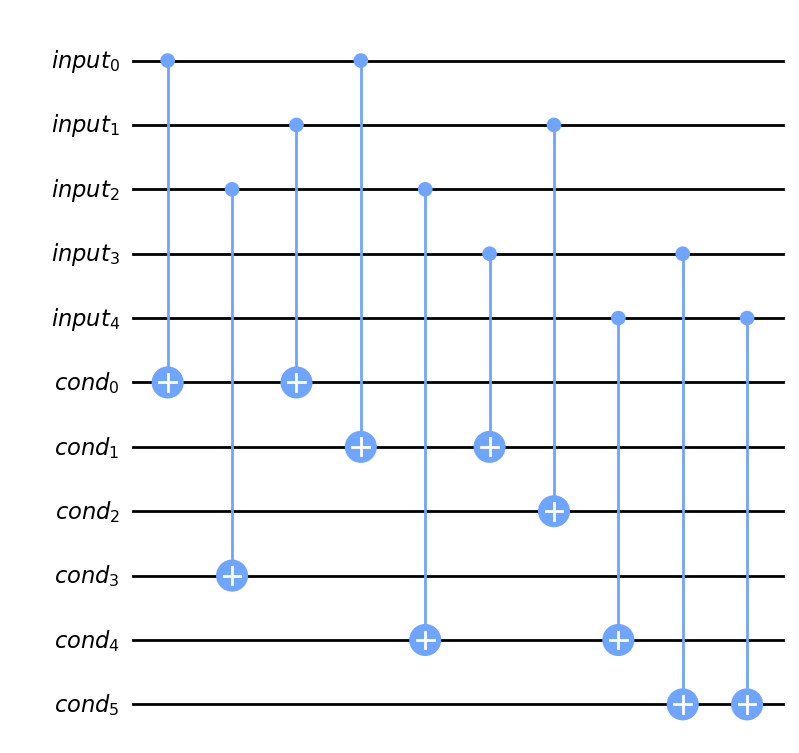

In [5]:
# conditions pour que le sudoku soit valide
cond = QuantumCircuit(input_reg, cond_reg)

cond.cx(input_reg[0], cond_reg[0])
cond.cx(input_reg[1], cond_reg[0])
cond.cx(input_reg[0], cond_reg[1])
cond.cx(input_reg[3], cond_reg[1])

cond.cx(input_reg[1], cond_reg[2])
# condition sur nombre donné 2 : soit 0

cond.cx(input_reg[2], cond_reg[3])
# condition sur nombre donné 2 : soit 0

cond.cx(input_reg[2], cond_reg[4])
cond.cx(input_reg[4], cond_reg[4])

cond.cx(input_reg[3], cond_reg[5])
cond.cx(input_reg[4], cond_reg[5])

display(cond.draw('mpl'))

cond = cond.to_gate(label="Conditions")

C:\Users\romai\AppData\Local\Temp\ipykernel_13240\2260568845.py:5: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  oracle.mct(cond_reg, kick_reg)


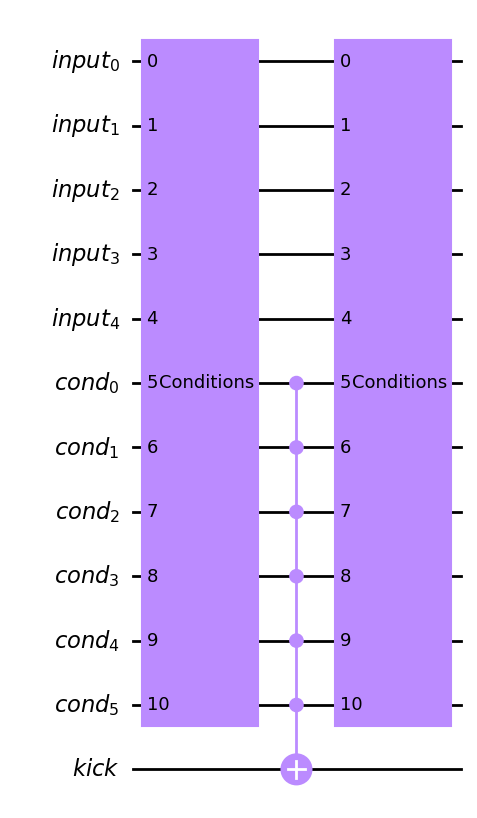

In [6]:
# oracle
oracle = QuantumCircuit(input_reg, cond_reg, kick_reg)

oracle.append(cond, input_reg[:]+cond_reg[:])
oracle.mct(cond_reg, kick_reg)
oracle.append(cond, input_reg[:]+cond_reg[:])

display(oracle.draw('mpl'))

oracle = oracle.to_gate(label="Oracle")

Nous utiliserons un diffuseur général.

C:\Users\romai\AppData\Local\Temp\ipykernel_13240\1303893022.py:7: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.mct()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use QuantumCircuit.mcx as direct replacement.
  diff.mct(input_reg[0:4], input_reg[4])


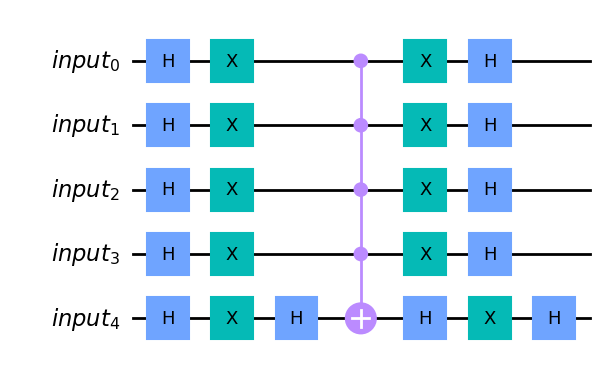

In [7]:
# diffuseur
diff = QuantumCircuit(input_reg)

diff.h(input_reg)
diff.x(input_reg)
diff.h(input_reg[4])
diff.mct(input_reg[0:4], input_reg[4])
diff.h(input_reg[4])
diff.x(input_reg)
diff.h(input_reg)

display(diff.draw('mpl'))

diff = diff.to_gate(label="Diffuseur")

On construit donc le circuit.

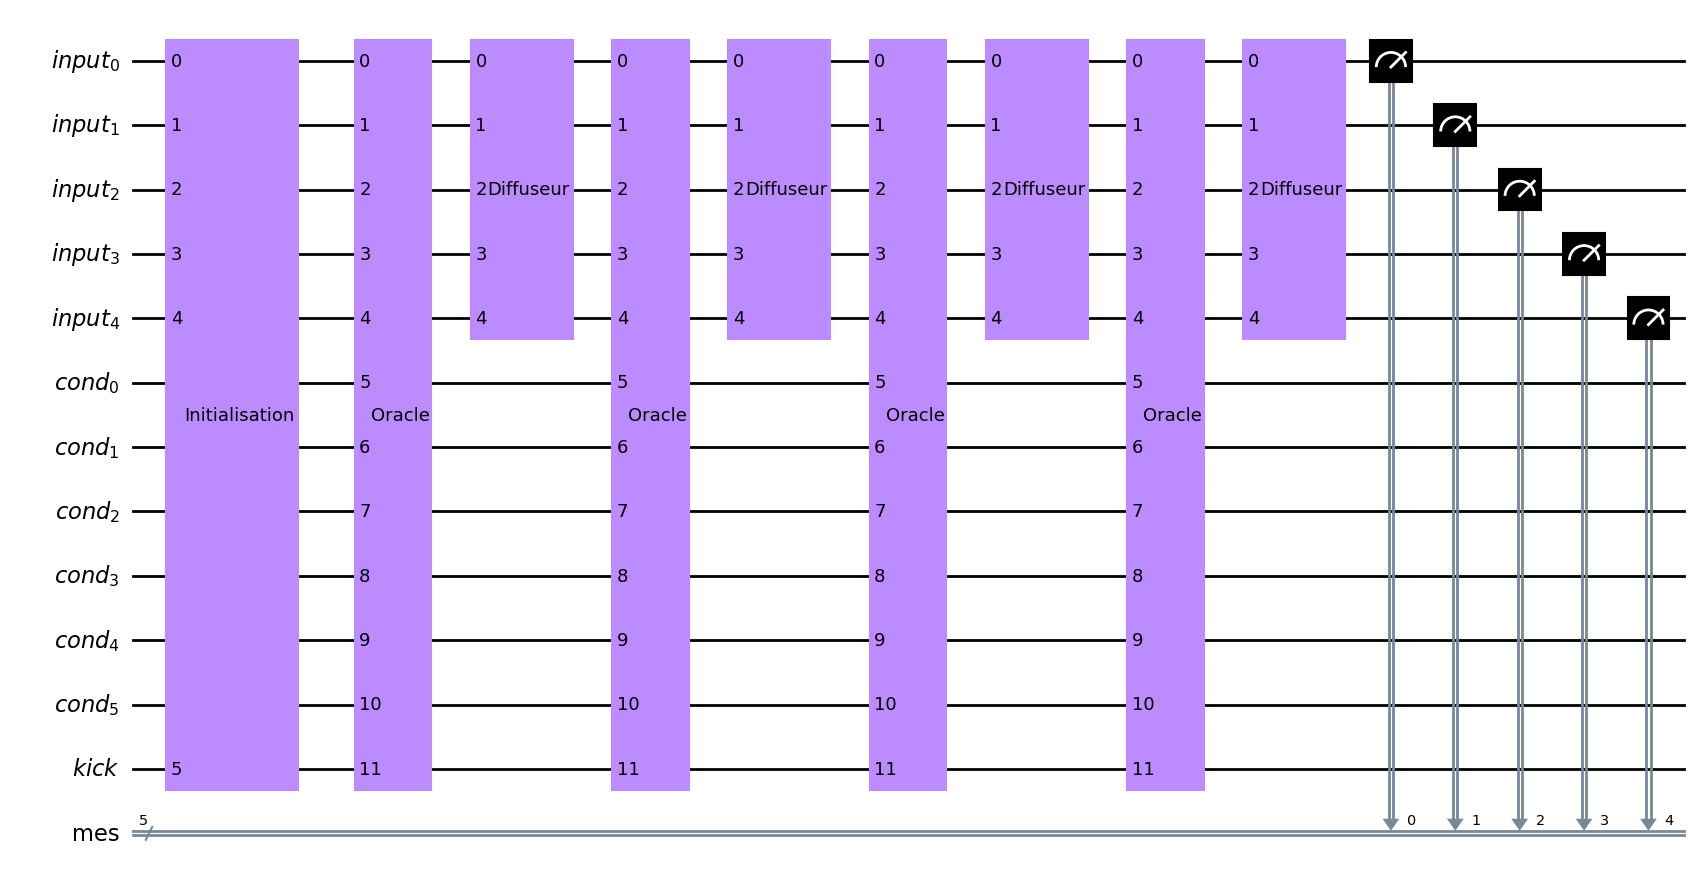

In [8]:
qc = QuantumCircuit(input_reg, cond_reg, kick_reg, mes_reg)
qc.append(init, input_reg[:]+kick_reg[:])
for _ in range(num_it):
    qc.append(oracle, input_reg[:]+cond_reg[:]+kick_reg[:])
    qc.append(diff, input_reg[:])
qc.measure(input_reg, mes_reg)

qc.draw('mpl')

Comme le circuit est très grand, on l'a executé sur un simulateur d'IBM ce qui donne le résultat suivant ce qui permet de compléter le sudoku selon la convention établie plus haut.

![Principe du circuit](Images/grov-img.png)

La liste 23332 est bien celle recherchée.

|1|_2_|_3_|
|-|-|-|
|**2**|**_3_**|**1**|
|**_3_**|**1**|**_2_**|